# Fitting the model

## Data Preprocessing

First we need to import the libraries and the data.

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression

# Set random seed 
RSEED = 42
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/data_clean_outlier.csv', index_col = 0)
df.head()

,backers_count,country,disable_communication,id,is_starrable,name,staff_pick,state,usd_pledged,usd_type,...,subcategory,city,region,city_type,creator_id,creator_num_projects,words_blurb,polarity_blurb,subjectivity_blurb,goal_usd
0,21,US,False,287514992,False,New Final Round Album,0,1,802.00000,international,...,Rock,Chicago,IL,Town,1495925645,1,26,0.178788,0.518182,200.0000
1,97,US,False,385129759,False,Princess Pals Enamel Pin Series,0,1,2259.00000,international,...,Mixed Media,Sacramento,CA,Town,1175589980,4,9,0.625000,1.000000,400.0000
2,88,US,False,681033598,False,Their Life Through Their Lens-the Amish and Me...,1,1,29638.00000,international,...,Photobooks,Columbus,OH,Town,1196856269,2,25,0.225000,0.366667,27224.0000
3,193,IT,False,1031782682,False,WAO: THE ECO EFFECT SHOES,0,1,49075.15252,international,...,Footwear,Venice,Veneto,Town,1569700626,2,13,0.000000,0.100000,45461.0028
4,20,US,False,904085819,False,Apple Watch Development Course,0,0,549.00000,domestic,...,Software,Redmond,WA,Town,1870845385,1,22,0.156250,0.400000,1000.0000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184367 entries, 0 to 209221
Data columns (total 29 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   backers_count          184367 non-null  int64  
 1   country                184367 non-null  object 
 2   disable_communication  184367 non-null  bool   
 3   id                     184367 non-null  int64  
 4   is_starrable           184367 non-null  bool   
 5   name                   184367 non-null  object 
 6   staff_pick             184367 non-null  int64  
 7   state                  184367 non-null  int64  
 8   usd_pledged            184367 non-null  float64
 9   usd_type               184330 non-null  object 
 10  yr_launched            184367 non-null  int64  
 11  mo_launched            184367 non-null  int64  
 12  wd_launched            184367 non-null  int64  
 13  yr_deadline            184367 non-null  int64  
 14  mo_deadline            184367 non-nu

Let us delete all the variables that are not going to be useful in our model:
+ **"id", "creator_id", "name"**: are not interesting to make a prediction
+ **"disable_communication", "is starrable"**: only False
+ **"city", "region"**: these two variables will create too many columns in the One Hot encoding process. We keep "country"
+ **"yr_deadline","mo_deadline", "wd_deadline"**: these variables are hihgly correlated with the launching date and "funding_phase"

In [4]:
df.dropna(
    axis=0,
    how='any',
    thresh=None,
    subset=None,
    inplace=True
)

In [5]:
df.drop(['id', 'name', 'yr_deadline',"mo_deadline", "wd_deadline", "city", "region","subcategory","creator_id"], axis=1, inplace=True)  
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176076 entries, 0 to 209221
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   backers_count          176076 non-null  int64  
 1   country                176076 non-null  object 
 2   disable_communication  176076 non-null  bool   
 3   is_starrable           176076 non-null  bool   
 4   staff_pick             176076 non-null  int64  
 5   state                  176076 non-null  int64  
 6   usd_pledged            176076 non-null  float64
 7   usd_type               176076 non-null  object 
 8   yr_launched            176076 non-null  int64  
 9   mo_launched            176076 non-null  int64  
 10  wd_launched            176076 non-null  int64  
 11  founding_phase         176076 non-null  int64  
 12  phase_before           176076 non-null  int64  
 13  main_category          176076 non-null  object 
 14  city_type              176076 non-nu

We split the variables in Categorical and Numerical variables.

In [6]:
cat_features = list(df.columns[df.dtypes==object])

num_features = list(df.columns[df.dtypes!=object])

num_features.remove('usd_pledged')
num_features.remove("backers_count")
num_features.remove("state")

 We also split the target of the data and then into Train and Test.

In [7]:
# Define predictors and target variable

X = df.drop(['usd_pledged', "backers_count", "state"], axis=1)
y = df['state']

print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 176076 observations in our dataset and 17 features
Our target vector has also 176076 values


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

## First model

We need to set a reference in order to compare how good our model is. We will use the *Logistic Regression* for this purpose. But first we need to convert the categorical variables into numerical with a *OneHotEconde* and we will also scale the data. 

In [9]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# Pipeline for categorical features 
cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy='constant', fill_value='missing')),
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

In [10]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [11]:
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [12]:
y_train_predicted = cross_val_predict(pipe_logreg, X_train, y_train, cv=5)

In [13]:
def print_scores(y_true, y_predicted):
# This function prints out the scores and the confussion matrix

    print('Cross validation scores:')
    print('-------------------------')
    print("Accuracy: {:.2f}".format(accuracy_score(y_true, y_predicted)))
    print("Recall: {:.2f}".format(recall_score(y_true, y_predicted)))
    print("Precision: {:.2f}".format(precision_score(y_true, y_predicted)))

    cm = confusion_matrix(y_true, y_predicted)
    print("")
    print("Confusion matrix:")
    print('-------------------------')
    print(cm)

In [14]:
print_scores(y_train, y_train_predicted)

Cross validation scores:
-------------------------
Accuracy: 0.75
Recall: 0.85
Precision: 0.76

Confusion matrix:
-------------------------
[[34939 22039]
 [12745 71137]]


In [15]:
pipe_logreg.fit(X_train, y_train)
y_pred = pipe_logreg.predict(X_test)

In [16]:
print_scores(y_test, y_pred)

Cross validation scores:
-------------------------
Accuracy: 0.76
Recall: 0.85
Precision: 0.77

Confusion matrix:
-------------------------
[[ 8749  5443]
 [ 3170 17854]]


## Model Benchmark

With a reference we can now try different models and see how the score, we will use the accuracy as metric.

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

In [18]:
models = [DecisionTreeClassifier(max_depth=6, random_state=RSEED ),
        RandomForestClassifier(n_estimators=200,max_depth=6 , random_state=RSEED, n_jobs = -1), 
        AdaBoostClassifier(random_state=RSEED),        
        xgb.XGBClassifier(random_state=RSEED, n_jobs = -1, eval_metric = "error"),
        RidgeClassifier(),
        LogisticRegression(max_iter=1000)]

model_name = ["DecisionTree", "RandomForest","AdaBoost","XGBoost", "RidgeRegression", "LogisticRegression"]
accuracy = []
recall = []
precision = []
accuracy_test = []
recall_test = []
precision_test = []

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

k = len(models)

for i in range(k):
    model = models[i].fit(X_train_prep, y_train)  
    y_pred = models[i].predict(X_train_prep)
    y_pred_test = models[i].predict(X_test_prep)
    
    accuracy.append(accuracy_score(y_train, y_pred))
    recall.append(recall_score(y_train, y_pred))
    precision.append(precision_score(y_train, y_pred))
    
    accuracy_test.append(accuracy_score(y_test, y_pred_test))
    recall_test.append(recall_score(y_test, y_pred_test))
    precision_test.append(precision_score(y_test, y_pred_test))
    
    print(f"Model {model_name[i]} done!")

df_scores = pd.DataFrame({"name": model_name,
                         "accuracy_train": accuracy,
                         "recall_train": recall,
                         "precission_train": precision,
                         "accuracy_test": accuracy_test,
                         "recall_test": recall_test,
                         "precission_test": precision_test,
                         })


Model DecisionTree done!
Model RandomForest done!
Model AdaBoost done!
Model XGBoost done!
Model RidgeRegression done!
Model LogisticRegression done!


In [19]:
df_scores.sort_values("accuracy_test", ascending = False).head(20)

,name,accuracy_train,recall_train,precission_train,accuracy_test,recall_test,precission_test
3,XGBoost,0.859172,0.900920,0.867665,0.840129,0.885607,0.852362
2,AdaBoost,0.794789,0.842565,0.818237,0.794412,0.844131,0.817457
1,RandomForest,0.790217,0.897165,0.782450,0.789386,0.896689,0.782338
0,DecisionTree,0.783075,0.862569,0.791775,0.782031,0.861349,0.791823
5,LogisticRegression,0.753727,0.848692,0.763940,0.755424,0.849220,0.766365
4,RidgeRegression,0.718025,0.859588,0.720716,0.718736,0.859351,0.722247


Text(0.5, 1.0, 'Model Accuracy ')

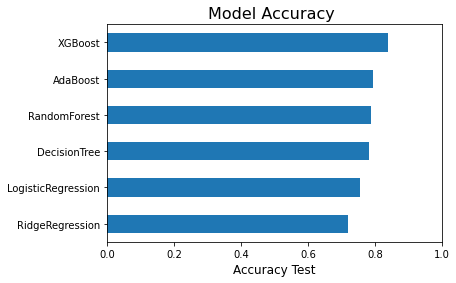

In [20]:
ax = plt.Figure()

plot1 = df_scores.sort_values("accuracy_test", ascending = True).plot(kind= "barh", x= "name", y = "accuracy_test", legend=None)
plt.xlim([0,1])
plot1.set_xlabel('Accuracy Test', fontsize = 12)
plot1.set_ylabel('', fontsize = 12)
plot1.set_title('Model Accuracy ', fontsize = 16)

Good! Now we will take the best candidates and optimaze them.

## XGBoost

We start with the best one: XGBoost. To find the best paramters we use a RandomizedSearch and then a GridSearch around the best parameters combination from the previous step

In [21]:
##Cell used for the optimization
'''
param_grid_xgb = {
    'n_estimators': [100],
    'max_depth': list(range(3,15)),
    "learning_rate": np.linspace(0.0001, 1).astype(float),
    'booster': ["gbtree"]}

# Instantiate random search and define the metric to optimize 
rs_xgb = RandomizedSearchCV(xgb.XGBClassifier(random_state = RSEED,n_jobs = -1), param_grid_xgb, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state = RSEED)

# Fit randomized search object to data
rs_xgb.fit(X_train_prep, y_train)

rs_xgb.best_params_
'''

'\nparam_grid_xgb = {\n    \'n_estimators\': [100],\n    \'max_depth\': list(range(3,15)),\n    "learning_rate": np.linspace(0.0001, 1).astype(float),\n    \'booster\': ["gbtree"]}\n\n# Instantiate random search and define the metric to optimize \nrs_xgb = RandomizedSearchCV(xgb.XGBClassifier(random_state = RSEED,n_jobs = -1), param_grid_xgb, scoring=\'accuracy\',\n                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state = RSEED)\n\n# Fit randomized search object to data\nrs_xgb.fit(X_train_prep, y_train)\n\nrs_xgb.best_params_\n'

In [22]:
# parameters around  the best model of the Random Search {'n_estimators': 25,'max_depth': 7,'learning_rate': 0.34700408163265306, 'booster': 'gbtree'}

'''
param_grid_xgb = {
    'n_estimators': [100],
    'max_depth' : [9],
    "learning_rate": list(np.linspace(0.1,0.2,3)),
    'booster': ["gbtree"]}

grid_xgb = GridSearchCV(xgb.XGBClassifier(random_state = RSEED, n_jobs = -1), param_grid=param_grid_xgb, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)
grid_xgb.fit(X_train_prep, y_train)

best_xgb = grid_xgb.best_estimator_
'''

'\nparam_grid_xgb = {\n    \'n_estimators\': [100],\n    \'max_depth\' : [9],\n    "learning_rate": list(np.linspace(0.1,0.2,3)),\n    \'booster\': ["gbtree"]}\n\ngrid_xgb = GridSearchCV(xgb.XGBClassifier(random_state = RSEED, n_jobs = -1), param_grid=param_grid_xgb, cv=5, scoring=\'accuracy\', \n                           verbose=5, n_jobs=-1)\ngrid_xgb.fit(X_train_prep, y_train)\n\nbest_xgb = grid_xgb.best_estimator_\n'

In [23]:
best_xgb = xgb.XGBClassifier(random_state = RSEED, n_jobs = -1,
                             n_estimators = 100, booster = "gbtree",
                             learning_rate = 0.1, max_depth = 9,
                            eval_metric = "error")

best_xgb.fit(X_train_prep, y_train)
y_train_pred = best_xgb.predict(X_train_prep)
y_pred = best_xgb.predict(X_test_prep)

#grid_xgb.best_params_

In [24]:
print_scores(y_train, y_train_pred)
print_scores(y_test, y_pred)

Cross validation scores:
-------------------------
Accuracy: 0.87
Recall: 0.91
Precision: 0.87

Confusion matrix:
-------------------------
[[45820 11158]
 [ 7714 76168]]
Cross validation scores:
-------------------------
Accuracy: 0.84
Recall: 0.89
Precision: 0.85

Confusion matrix:
-------------------------
[[10946  3246]
 [ 2326 18698]]


Well, we got an extra % of accuracy. Let us check out which are the most important parameters in our model.

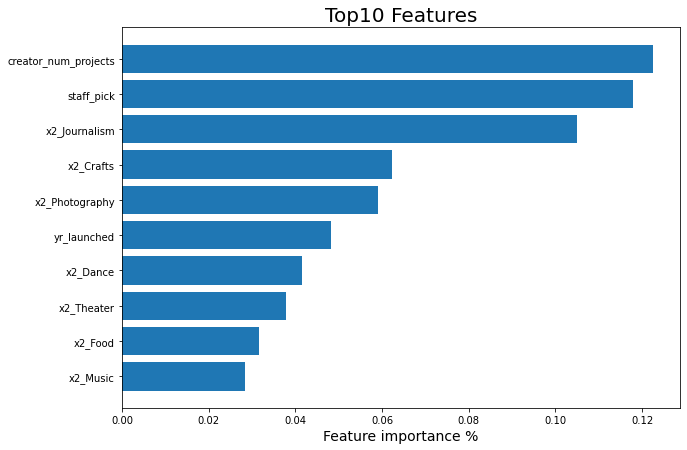

In [30]:
hot_encoder = preprocessor.named_transformers_["cat"]['1hot']
hot_encoder_names = hot_encoder.get_feature_names()
column_names = num_features + list(hot_encoder_names)

importance = list(best_xgb.feature_importances_)


fig, ax = plt.subplots(figsize = (10,7))

df_importance = pd.DataFrame({"Feature": column_names, "Importance": importance})
df_importance.sort_values("Importance", ascending = True, inplace = True)

ax.barh(df_importance["Feature"].tail(10), df_importance["Importance"].tail(10))

ax.set_xlabel('Feature importance %', fontsize = 14)
ax.set_ylabel('', fontsize = 12)
ax.set_title('Top10 Features', fontsize = 20)

plt.savefig('Features_importance.png', transparent=True)

In [31]:
model_name.append("XGBoost optimized")

accuracy.append(accuracy_score(y_train, y_train_pred))
recall.append(recall_score(y_train, y_train_pred))
precision.append(precision_score(y_train, y_train_pred))
    
accuracy_test.append(accuracy_score(y_test, y_pred))
recall_test.append(recall_score(y_test, y_pred))
precision_test.append(precision_score(y_test, y_pred))

## AdaBoost

We use the same strategy to optimize the AdaBoost model.

In [32]:
''''

param_grid_ada = {
    'n_estimators': np.linspace(100, 500, 20).astype(int)}

# Instantiate random search and define the metric to optimize 
rs_ada = RandomizedSearchCV(AdaBoostClassifier(random_state=RSEED), param_grid_ada, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state=RSEED)

# Fit randomized search object to data
rs_ada.fit(X_train_prep, y_train)

best_ada = rs_ada.best_estimator_

y_train_pred = best_ada.predict(X_train_prep)
y_pred = best_ada.predict(X_test_prep)
rs_ada.best_params_
print_scores(y_train, y_train_pred)
print_scores(y_test, y_pred)
'''

"'\n\nparam_grid_ada = {\n    'n_estimators': np.linspace(100, 500, 20).astype(int)}\n\n# Instantiate random search and define the metric to optimize \nrs_ada = RandomizedSearchCV(AdaBoostClassifier(random_state=RSEED), param_grid_ada, scoring='accuracy',\n                  cv=5, verbose=5, n_jobs=-1, n_iter=10, random_state=RSEED)\n\n# Fit randomized search object to data\nrs_ada.fit(X_train_prep, y_train)\n\nbest_ada = rs_ada.best_estimator_\n\ny_train_pred = best_ada.predict(X_train_prep)\ny_pred = best_ada.predict(X_test_prep)\nrs_ada.best_params_\nprint_scores(y_train, y_train_pred)\nprint_scores(y_test, y_pred)\n"

In [33]:

'''
param_grid_ada = {
    'n_estimators': np.linspace(150, 250, 3).astype(int),
    "learning_rate": np.linspace(0.5, 1, 3).astype(float)}

grid_ada = GridSearchCV(AdaBoostClassifier(random_state=RSEED), param_grid=param_grid_ada, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

grid_ada.fit(X_train_prep, y_train)

best_grid_ada = grid_ada.best_estimator_

y_train_pred = best_grid_ada.predict(X_train_prep)
y_pred = best_grid_ada.predict(X_test_prep)

grid_ada.best_params_
'''

'\nparam_grid_ada = {\n    \'n_estimators\': np.linspace(150, 250, 3).astype(int),\n    "learning_rate": np.linspace(0.5, 1, 3).astype(float)}\n\ngrid_ada = GridSearchCV(AdaBoostClassifier(random_state=RSEED), param_grid=param_grid_ada, cv=5, scoring=\'accuracy\', \n                           verbose=5, n_jobs=-1)\n\ngrid_ada.fit(X_train_prep, y_train)\n\nbest_grid_ada = grid_ada.best_estimator_\n\ny_train_pred = best_grid_ada.predict(X_train_prep)\ny_pred = best_grid_ada.predict(X_test_prep)\n\ngrid_ada.best_params_\n'

In [34]:
ada2 = AdaBoostClassifier(n_estimators=225, learning_rate=1.0, random_state=RSEED)
ada2.fit(X_train_prep, y_train)

y_train_pred = ada2.predict(X_train_prep)
y_pred = ada2.predict(X_test_prep)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_pred)

Cross validation scores:
-------------------------
Accuracy: 0.80
Recall: 0.84
Precision: 0.82

Confusion matrix:
-------------------------
[[41830 15148]
 [13525 70357]]
Cross validation scores:
-------------------------
Accuracy: 0.79
Recall: 0.84
Precision: 0.82

Confusion matrix:
-------------------------
[[10362  3830]
 [ 3401 17623]]


In [35]:
model_name.append("AdaBoost optimized")

accuracy.append(accuracy_score(y_train, y_train_pred))
recall.append(recall_score(y_train, y_train_pred))
precision.append(precision_score(y_train, y_train_pred))
    
accuracy_test.append(accuracy_score(y_test, y_pred))
recall_test.append(recall_score(y_test, y_pred))
precision_test.append(precision_score(y_test, y_pred))

## Voting Classifier

In [36]:
from sklearn.ensemble import VotingClassifier

# Cell used for the optimization
# {'rf__n_estimators': 200,'rf__max_features': 8,'rf__max_depth': 10,'dt__max_depth': 10}

'''
clf1 = DecisionTreeClassifier(random_state=RSEED)
clf2 = RandomForestClassifier(random_state=RSEED)
clf3 = LogisticRegression(random_state=RSEED)

params = {'dt__max_depth': [5, 10], 'rf__n_estimators': [20, 200],'rf__max_depth': [5, 10], 'rf__max_features': [6, 8], }

eclf = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('lr', clf3)], voting='hard')

random_search = RandomizedSearchCV(eclf, param_distributions=params,n_iter=4)
random_search.fit(X_train_prep, y_train)

best_rs = random_search.best_estimator_
random_search.best_params_

'''

"\nclf1 = DecisionTreeClassifier(random_state=RSEED)\nclf2 = RandomForestClassifier(random_state=RSEED)\nclf3 = LogisticRegression(random_state=RSEED)\n\nparams = {'dt__max_depth': [5, 10], 'rf__n_estimators': [20, 200],'rf__max_depth': [5, 10], 'rf__max_features': [6, 8], }\n\neclf = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('lr', clf3)], voting='hard')\n\nrandom_search = RandomizedSearchCV(eclf, param_distributions=params,n_iter=4)\nrandom_search.fit(X_train_prep, y_train)\n\nbest_rs = random_search.best_estimator_\nrandom_search.best_params_\n\n"

In [37]:
clf1 = DecisionTreeClassifier(random_state=RSEED, max_depth = 10)
clf2 = RandomForestClassifier(random_state=RSEED, max_depth = 10, max_features = 8, n_estimators = 200)
clf3 = LogisticRegression(random_state=RSEED)

eclf = VotingClassifier(estimators=[('dt', clf1), ('rf', clf2), ('lr', clf3)], voting='hard')

In [40]:
eclf.fit(X_train_prep,y_train)

y_train_pred = eclf.predict(X_train_prep)
y_pred = eclf.predict(X_test_prep)

print_scores(y_train, y_train_pred)
print_scores(y_test, y_pred)

Cross validation scores:
-------------------------
Accuracy: 0.82
Recall: 0.90
Precision: 0.82

Confusion matrix:
-------------------------
[[40542 16436]
 [ 8744 75138]]
Cross validation scores:
-------------------------
Accuracy: 0.82
Recall: 0.89
Precision: 0.82

Confusion matrix:
-------------------------
[[10029  4163]
 [ 2298 18726]]


In [41]:
model_name.append("Voting Classifier")

accuracy.append(accuracy_score(y_train, y_train_pred))
recall.append(recall_score(y_train, y_train_pred))
precision.append(precision_score(y_train, y_train_pred))
    
accuracy_test.append(accuracy_score(y_test, y_pred))
recall_test.append(recall_score(y_test, y_pred))
precision_test.append(precision_score(y_test, y_pred))

In [42]:
df_scores = pd.DataFrame({"name": model_name,
                         "accuracy_train": accuracy,
                         "recall_train": recall,
                         "precission_train": precision,
                         "accuracy_test": accuracy_test,
                         "recall_test": recall_test,
                         "precission_test": precision_test,
                         })

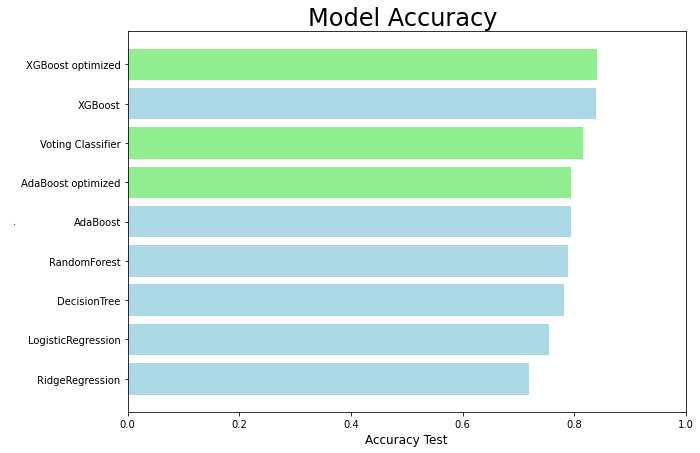

In [44]:
df_scores.sort_values("accuracy_test", ascending = True , inplace= True)

fig, ax = plt.subplots(figsize = (10,7))

color_list = ["lightblue"] * len(df_scores["name"].to_list())

color_list[-1] = "lightgreen"
color_list[-4] = "lightgreen"
color_list[-5] = "lightgreen"

#plot1 = df_scores.sort_values("accuracy_test", ascending = True).plot

hbars = ax.barh(df_scores["name"], df_scores["accuracy_test"], align='center', color =color_list)

plt.xlim([0,1])

ax.set_xlabel('Accuracy Test', fontsize = 12)
ax.set_ylabel('.')
ax.set_title('Model Accuracy ', fontsize = 24)

plt.savefig('Models_accuracy.png', transparent=False)